In [1]:
import re
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
%matplotlib inline

# Load ICLR ground truth

In [2]:
data_dir = Path("../data")
df_iclr = pd.read_excel(data_dir / "ICLR2022.xlsx")

Look at previously defined labels for each column:

In [3]:
df_iclr["Threat"].unique()

array(['Model Extraction', 'Poisoning', 'Data Extraction', 'Robustness',
       'Evasion'], dtype=object)

In [4]:
df_iclr["Context"].unique()

array(['Defense', 'Attacks', 'Bias', 'Robustness measures',
       'Attacks/Defense'], dtype=object)

In [5]:
techniques_by_threat = df_iclr.groupby("Threat")["Technique"].unique().explode().to_frame()
techniques_by_threat

,Technique
Threat,
Data Extraction,Differential Privacy Learning
Data Extraction,Data Encryption/Data learnability locking
Data Extraction,Gradient Leakage (federated learning)
Data Extraction,Property Inference Attacks/Differencial Privac...
Data Extraction,Defense against Membership Inference Attacks
Data Extraction,User privacy
Data Extraction,Membership Inference
Evasion,Adversarial Examples
Evasion,Robust/Adversarial Training


# ICML analysis

## Load ICML data (mostly unlabelled)

Load

In [6]:
df_items = pd.read_parquet(data_dir / "items.parquet")
df_authors = pd.read_parquet(data_dir / "authors.parquet")
df_keywords = pd.read_parquet(data_dir / "keywords.parquet")
df_author_item_relations = pd.read_parquet(data_dir / "author_item_relations.parquet")
df_keyword_item_relations = pd.read_parquet(data_dir / "keyword_item_relations.parquet")

df_items["conference"] = "ICML"
df_items["year"] = 2022                                                                
df_keywords["value"] = df_keywords["value"].str.strip()

df_keywords_by_item = pd.merge(df_keywords, df_keyword_item_relations, left_on="id", right_on="keyword_id", how="inner").drop("id", axis=1)
df_keywords_by_item = pd.merge(df_keywords_by_item, df_items[["id", "item_type"]], left_on="confitem_id", right_on="id", how="inner").drop("id", axis=1)

attack_keywords = "adversar|poison|attack|adversarial machine learning|model theft|model extraction|data extraction|data theft|model stealing|data stealing|evasion|model ownership|watermark"
privacy_keywords = "differential privacy|differentially private|federated"
robustness_keywords = "robust" 
fairness_keywords = "trust|fair|bias"

def select_rows_containing_keywords(df: pd.DataFrame, keyword_ptn: str) -> pd.DataFrame:
    return df[
        df["title"].str.lower().str.contains(keyword_ptn) | 
        df["abstract"].str.lower().str.contains(keyword_ptn)
    ]

df_icml = select_rows_containing_keywords(df_items, "|".join((attack_keywords, robustness_keywords))).reset_index(drop=True)
df_icml_abs = df_icml[~pd.isnull(df_icml["abstract"])]

sample of all robustness + adversarial to manually label

In [7]:
df_manual_check = (
    df_icml
    .loc[~pd.isnull(df_icml.abstract), ["id", "title", "abstract"]]
    .sample(50, random_state=10)
    .reset_index(drop=True)
)

let's pick an adversarial only (non-robustness-related) sample of non duplicates to collect some more labels

In [8]:
df_icml_adv_only = select_rows_containing_keywords(df_items, attack_keywords).reset_index(drop=True)
df_icml_adv_only_abs = df_icml_adv_only[~pd.isnull(df_icml_adv_only["abstract"])]
df_icml_adv_sample = df_icml_adv_only_abs.sort_values(by="item_type").groupby("title").last().sample(25, random_state=10).reset_index()

### load manually labelled samples for testing/few-shot learning

(those above, plus one or two others hand picked)

In [9]:
df_test = pd.read_csv("annotated_abstracts_manual.csv")

perhaps clarify labels here? replace evasion with adversarial attack/perturbation etc

split up the (multi-)labels

In [10]:
split_threats = df_test["threat_manual"].str.split(",", expand=True); split_threats.columns = ["threat_1", "threat_2"]
split_contexts = df_test["context_manual"].str.split(",", expand=True); split_contexts.columns = ["context_1", "context_2"]
df_test = df_test.join(split_threats).join(split_contexts).drop(["threat_manual", "context_manual"], axis=1)

Add back abstracts

In [11]:
df_test = pd.merge(df_test, df_icml, how="inner", left_on="id", right_on="id")

In [12]:
threats = np.unique(df_test[["threat_1", "threat_2"]].fillna("None"))
contexts = np.unique(df_test[["context_1", "context_2"]].fillna("None"))

## Zero-shot classification (ChatGPT)

In [15]:
import asyncio
import json
import os
import random
import time
from pathlib import Path

from tenacity import retry, wait_fixed, wait_random
from revChatGPT.revChatGPT import Chatbot
#from asyncChatGPT.asyncChatGPT import Chatbot


@retry(wait=wait_fixed(3.) + wait_random(0, 2.))
def get_response(prompt: str, chatbot: Chatbot) -> dict:
    return chatbot.get_chat_response(prompt)

def random_wait(min_wait=2., max_wait=4.):
    time.sleep(min_wait + random.random() * (max_wait - min_wait))
    

#cfg_file = Path(os.getenv("HOME")) / "revChatGPT/config.json"
#cfg = json.load(open(cfg_file, "r"))

In [16]:
os.environ["DISPLAY"] = ":1"

In [ ]:
# cfg = {
#     "session_token":"eyJhbGciOiJkaXIiLCJlbmMiOiJBMjU2R0NNIn0..GveCyxZ00iAZRU3j.qYiganTm3E8rKrt2AGFreLn37y6JHBGfzYdyLSPTVgxAMRtxqjRALNaJ7T0z3YgbJIjfKOFIgy6GBIP4IDV4QdcjV8SOuhT1_WqrpkAQ8Ig9sgWB4T69Q2RnskNs-39K5s82G5PfOpgw5bg7539obG0OtcNOSexx4Ek0vs-pTo-dJo9fN1zL00WUbJrT47UkdrFCnJD01Su8S5bwXIobVBpxGxvKcAL2nlIxALBe9JL6uoSz1dA_bhroFXpN0RPlkd0FHQHkH8MhRhNULaPUrKrhp7HxLIyE95XZj7_U2ZCUJVqSX3McdLyuiClMUdBKEpuvEA-aS4rgheI40hVefBVir_7bbmReuifi67_5vBFmVyGaVxtsBwqdM-o6cFFJm4EA2rDWP6rJnm7f8KEr_ldi_biqnamxQsXtV96m1NSGIiZvk3eVm_Efely4JIg3miHVGqo2ZHBdcI5vCu1sA1NUSGg9uLh58TqBgHBm_kEGLe_OALx4PdJUdsUDDZ8xavZzIYFYQvuHinwSSVG0pJiUIcdunILja4iWXT2vuYJtN8PIwbIZLEm8x78_b0zzWQAsUyqVeuqo0uT5lSy5Czl-8pMQ-0-DRYSZB3baxf_Soz2eItiQ9ig1F_k2m8Vk53JlhnZOCo8FMTQ4fXZo4cGVqsiQmkfBegaHbKgON7NH2dVKTcyP1G8PS7Mbz6BsQ56q6RvSegThomG2rSboj4AsKnljlYcImmXzniyncKV5xiL4J4qh9YntJuSsA3lqcwL8UoPTIoTmhQ9_2mhoOKug_GQkZtN9cQnxrlnrezstUj8JKvCcFAuNxy4h6NTGXB75xJfTGm2UH5ECyhR7_imAYNnO5hCLRQY6rIGxuBp2XKLdLzBCf7OuT_z4MKyzIgq0RaFAjjYpVrmwwuoQZdPS8iuiDDpeP3p3WlBbN07Tujb6rjmzSEnuyKn3MguBevlbl-8L5Ol0IqLBqhL9DrGrZq6GtIHQkcDfMT1o2QnCpENbER7bju4K8elXDydXrTfuoNyCrwYsmNdmCFoJ6uFhMASMbyBNMqtxE4wtQw9i2_Wm3PF7gcayzfKKBKgvi7OIPgDgswVf70GFJws_UVH4vxllU4A8b5_uYnT4YtEgkNmQtJnHMVfPeMO-L183A7unNO43BK_jIZ0G13Rs3IAeKvmyGtXRugL_HWlnbz-z5_Yq_e-4p1-QMY1AMfAHfj6fmLOonxO50sAQBJBapthXlB_gdQEWTBKlyuQnWUldaM17HG7RFzU7M97mXMNAsuMlVXq5FS1hSn4UZYR8I9flubFKy0WmpP0wW2_WHHrH3b4zH9iz_3Db6HKJOgcaczPE8Lr7P2BnXgx7Da8GCJWPDznZln0IFayoFr8EKfCcc2QMh8-2XNyEVY75o4v3fG1XH_kt-z56mqU7J7BzaeF0uyqoIuBzadPZD1oymQBI7KDffvDTf-Ti0iZ0peR6vaJpFgQm814b50eMLRUX1Zb1vmJBGk-GV5aROpc4JWQtF7d2gPGunUL5k6-iqjjxGbjn_4zut3ZjfVSWBFeelYizovyXKUTJSZYHz-y6Lp8tHPjeotlwQMn222AJZg6N4oUp2pNM6r5GtYjeq1s7xDZfSqZtQRFwiEzigBUn7LI0CLnePVc-ovpfQnvScu86hxaWLUo8xAOBa7zHyIZmbU1Sq0vesZI59_U4oVRfzDC18q_V4j2iN7rxIfAsM1CuwWykA8nvOcyTotEJBZFk_tzYJXlyOM0zm4bfstDlZHKMjjPu59CixwhEOj-bhWrgnV6IbcSxZSGEMHOiLOgTQWOV8UWdrKxndk5XzijnU6XJi-KLuhOJ6xe4e06OH2I4YefD5MTRTFfd1UKZ5hagTueBOEdDRFccP1e0bi2rAmEttL0hs-2IG15gW4nB8UTFTeQIF8dQbfL14Yf40WwLzmGvow_Jw-YHhktWn0J0PlqX0PgePkJyEqbMyyEJggPi2TxcbaA_wKfOK7mVIH9Q3zCt3O4wHcyg-5eDMqFqwSPma-7vnlQglObQiTIlrYnTrq61ptlx49x3A1wShITU3cCUEMvUB67Er0iIrZaLpyQ22GYEOGikF0TrHG-c0yyVbJ1uRxhTBU7EO2H9QdOdR8OTtYrT8ZoaxDiFinXCJtICZh4sCXp1XeQoymC5zGj-dxi5vrkw-fqdy58lwZIunr44tgOsj052AQAlUC1wVTVgWjNEX2iT6pMCkhCXvLGYjZc5yS3x0mh-B5FOe9J74TKNwBtwUf-PwEMmbQbrZWCrOyRYE3FQbcSPOZ2Slq6vbnVaKHcUf1QeKlrMdeydMBCsglBpWxdnDFkmXXOK_SbRnmceXJORFXCKGFhSGHtlQXflHCVbeKfuB2k4DldjbhlTRxJIodOKj6Jpdwut2Y9c8B8wddin8nY5sCQN7PPeSItldMib7xkgYKGOOPyp5g.q9MwSue66y4RRFSkybnMzw"
# }

# chatbot = Chatbot(cfg, conversation_id=None)

Intro prompt to prime for questions:

In [17]:
threats = (
    "Model extraction attack",
    "Poisoning attack",
    "Data extraction attack",
    "Evasion attack",
    "Model bias",
    "General lack of robustness",
)

In [18]:
contexts = (
    "Specific adversarial defense methods",
    "Specific adversarial attack methods",
    "Methods which improve general adversarial robustness",
    "Addressing model bias"
)

In [19]:
techniques = tuple(df_iclr["Technique"].unique())
print(techniques)

('Deterrent Control (Model Watermarking)', 'Backdoor Pattern', 'Differential Privacy Learning', 'Bias removal via relabeling', 'Adversarial Examples', 'Robust/Adversarial Training', 'Corrective approach', 'Data Encryption/Data learnability locking', 'Label Uncertainty', 'Robustness Certification', 'Adversarial Examples and Robust/Adversarial Training', 'Adversarial Examples Transferrability', 'Preventive Controls', 'Preprocessing', 'Fairness guarantee', 'Gradient Leakage (federated learning)', 'Property Inference Attacks/Differencial Privacy Defense', 'Adversarial Examples (for explanation methods)', 'Fairness', 'Defense against Membership Inference Attacks', 'Robust Inference', 'User privacy', 'Membership Inference', 'Side-channel attacks')


In [20]:
primer = fr"""Let's talk for a moment about the topic of adversarial machine learning. 

Can you explain each of the following threats succinctly? These threats are: {threats}."""

In [21]:
question_prompt = r"""
I am shortly going to present you some hypothetical abstracts. I would like to ask you to answer some questions about them.

The subject we are interested in is adversarial machine learning. Whenever I refer to an "evasion attack", I mean an attack in which
adversarial noise is deliberately given to a model.

For each of the abstracts I will present you,
I would like you to answer the following questions. In each case, choose one of the answers explicitly 
provided in the question (unless stated otherwise in the question).
For the multiple choice questions, you may choose the most relevant two answers 
if more than one is appropriate.

Here are the questions I would like you to answer for each abstract. If a given case is
really not clear, you may answer "Not clear".

Q1: Which, if any, of the following threats to machine learning models is addressed 
in the abstract: {threats}. If none, answer "None". 
Q2: Which, if any, of the following context(s) is the abstract 
relevant to: {contexts}. If none, answer "None". 
Q3: Which, if any, of the following techniques is described in 
the abstract? {techniques}. If none, answer "None". 
Q4: Which, if any, industries or applications are explicitly referenced?
For example, "Media", "Healthcare", or "Automotive". You can use any word you find most appropriate here.

Present your response in the format of a JSON string. The keys are Q1 to Q4, and the values are the answers to the respective questions.

I will now send you the abstracts one at at a time. Please answer to the best of your ability.

Before I do that, firstly please confirm that you understand what I am asking of you.
""".format(threats=threats, contexts=contexts, techniques=techniques)

In [19]:
print(primer)

Let's talk for a moment about the topic of adversarial machine learning. 

Can you explain each of the following threats succinctly? These threats are: ('Model extraction attack', 'Poisoning attack', 'Data extraction attack', 'Evasion attack', 'Model bias', 'General lack of robustness').


In [20]:
print(question_prompt)


I am shortly going to present you some hypothetical abstracts. I would like to ask you to answer some questions about them.

The subject we are interested in is adversarial machine learning. Whenever I refer to an "evasion attack", I mean an attack in which
adversarial noise is deliberately given to a model.

For each of the abstracts I will present you,
I would like you to answer the following questions. In each case, choose one of the answers explicitly 
provided in the question (unless stated otherwise in the question).
For the multiple choice questions, you may choose the most relevant two answers 
if more than one is appropriate.

Here are the questions I would like you to answer for each abstract. If a given case is
really not clear, you may answer "Not clear".

Q1: Which, if any, of the following threats to machine learning models is addressed 
in the abstract: ('Model extraction attack', 'Poisoning attack', 'Data extraction attack', 'Evasion attack', 'Model bias', 'General lac

In [ ]:
primer_answer = get_response(primer, chatbot)

In [ ]:
#answer = get_response(question_prompt, chatbot)

In [ ]:
#answer

For test set

In [ ]:
answers = pd.Series(index=df_test["id"])

In [ ]:
for ix, (_, row) in enumerate(df_test.iterrows()):
    print(f"\n\n--- {ix}")
    if not pd.isnull(answers.loc[ix]):
        if answers_unlabeled.loc[ix][0] == "{":
            print("skip id already calculated and valid-looking")
            continue
    # re-iterate question every 2 so it doesnt lose context
    if not ix % 2:
        get_response(question_prompt, chatbot)
    abs_ = row.abstract
    print("Abstract:")
    print(abs_)
    print("Labels:")
    print(row[["threat_1", "threat_2", "context_1", "context_2"]])
    prompt = (
        f"Good. Here is the abstract:\n\n'{abs_}'\n\nPlease answer the questions and format your response as the "
        "aforementioned JSON string only."
    )
    random_wait()
    answer = get_response(prompt, chatbot)
    print("Response:")
    print(answer["message"])
    answers.loc[row.id] = answer["message"]
answers.to_csv("./answers.csv")

For full set

In [ ]:
answers_unlabeled = pd.Series(index=df_icml_abs["id"])

for ix, (_, row) in enumerate(df_icml_abs.iterrows()):
    print(f"\n\n--- {ix}")
    # skip those already done in test set
    if row["id"] in df_test["id"].values:
        print("skip id in test set", row["id"])
        continue
    # skip those already calculated on interrupted loop
    # if the answer doesn't look like a valid JSON, redo anyway
    if not pd.isnull(answers_unlabeled.loc[ix]):
        if answers_unlabeled.loc[ix][0] == "{":
            print("skip id already calculated and valid-looking")
            continue
    # re-iterate question every 2 so it doesnt lose context
    if not ix % 2:
        get_response(question_prompt, chatbot)
    abs_ = row.abstract
    print("Abstract:")
    print(abs_)
    prompt = (
        f"Good. Here is the abstract:\n\n'{abs_}'\n\nPlease answer the questions and format your response as the "
        "aforementioned JSON string only."
    )
    random_wait()
    answer = get_response(prompt, chatbot)
    print("Response:")
    print(answer["message"])
    answers_unlabeled.loc[row.id] = answer["message"]
answers_unlabeled.to_csv("./answers_unlabeled.csv")

### Process

In [224]:
def parse_chatgpt_responses(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and parse raw responses into df columns
    """
    df = df.rename({"0": "response"}, axis=1)
    # try to grab a json from somewhere in response, ignoring whitespace padding
    df = df.join(
        df["response"]
        .str
        .extract("(?s:.*)(?P<json>\{\s*(?s:.*)\s*\})(?s:.*)")
        .json
        .str
        .replace("\n", "")
    )
    # get rows where json successfully parsed and parsing failed
    df_json = df[~df["json"].isna()]
    df_no_json = df[df["json"].isna()]
    # parse jsons
    df_json = (
        df_json
        .join(
            df_json["json"].apply(lambda x: pd.Series(json.loads(x)))
        )
        .drop("json", axis=1, errors="ignore")
    )
    # try to match Q keys and parse answers directly
    ptn = (
        ".*"
        "Q1\s?:?(?P<Q1>.*)"
        "Q2\s?:?(?P<Q2>.*)"
        "Q3\s?:?(?P<Q3>.*)"
        "Q4\s?:?(?P<Q4>.*)"
        ".*"
    )
    df_no_json = (
        df_no_json
        .drop("json", axis=1, errors="ignore")
        .join(
            df_no_json["response"].str.extract(
                ptn,
                flags=re.DOTALL
            )
        )
    )
    # join both cases
    df = pd.concat([df_json, df_no_json])
    # clear whitespace, quotes and brackets
    for c in ("Q1", "Q2", "Q3", "Q4"):   
        df[c] = df[c].str.replace("[\n\t]", "", regex=True).str.strip(" \"\'")
    # rename question numbers to be more descriptive of predictions
    df = df.rename({
        "Q1": "threat_pred",
        "Q2": "context_pred",
        "Q3": "techniques_pred",
        "Q4": "industries_pred"
    }, axis=1)
    return df

Clean

In [225]:
df_ans_test = pd.read_csv("answers.csv")
df_ans_unlabeled = pd.read_csv("answers_unlabeled.csv")

In [226]:
df_ans_test = parse_chatgpt_responses(df_ans_test)

In [227]:
df_ans_unlabeled = df_ans_unlabeled[~df_ans_unlabeled["id"].isin(df_ans_test["id"])]
df_ans_unlabeled = parse_chatgpt_responses(df_ans_unlabeled).dropna(how="any")

Define verbose label -> short label mappings for simplifying model outputs

In [228]:
threats_short = {
    'Data extraction attack': "Data Extraction",
    'Evasion attack' : "Evasion",
    'General lack of robustness' : "Robustness",
    'Model bias': "Bias",
    'Model extraction attack': "Model Extraction",
    'Poisoning attack': "Poisoning",
    'None': "Not relevant"
}

In [229]:
contexts_short = {
    'Addressing model bias': "Bias",
    'Methods which improve general adversarial robustness': "Robustness measures",
    'Specific adversarial attack methods': "Attacks",
    'Specific adversarial defense methods': "Defense",
    'None': "Not relevant"
}

In [230]:
df_test_gpt = pd.merge(df_test, df_ans_test.drop("response", axis=1), left_on="id", right_on="id").groupby("id").first()

Shorten labels

In [231]:
df_test_gpt["threat_pred"] = df_test_gpt["threat_pred"].replace(threats_short, regex=True)
df_test_gpt["context_pred"] = df_test_gpt["context_pred"].replace(contexts_short, regex=True)

#### Confusion matrices: threat

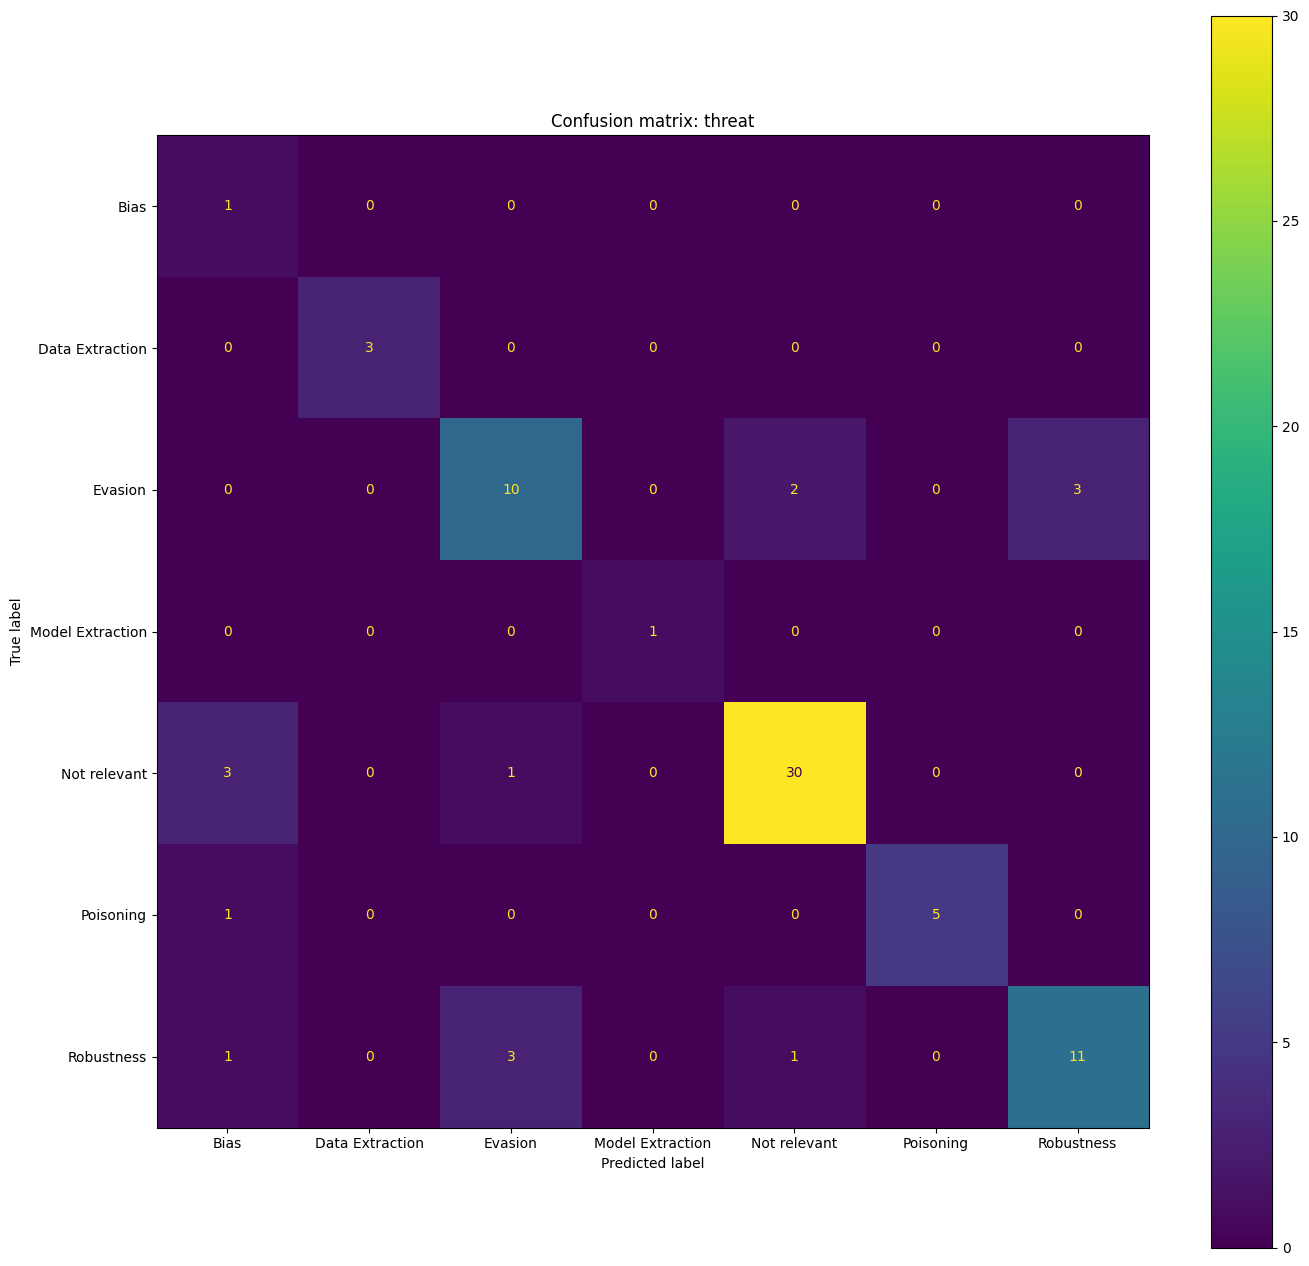

In [232]:
df_cm_swaplabels = df_test_gpt.copy()
threat_2nd_agree = df_test_gpt[df_test_gpt["threat_2"] == df_test_gpt["threat_pred"]]
df_cm_swaplabels.loc[threat_2nd_agree.index, "threat_1"] = threat_2nd_agree["threat_2"]
labels = sorted(df_cm_swaplabels[["threat_1", "threat_pred"]].stack().unique())
cm = confusion_matrix(df_cm_swaplabels["threat_1"], df_cm_swaplabels["threat_pred"], labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_title("Confusion matrix: threat")
ConfusionMatrixDisplay.from_predictions(df_cm_swaplabels["threat_1"], df_cm_swaplabels["threat_pred"], ax=ax)

Rows where I disagree with GPT on primary **threat** label

In [233]:
df_threat_1_disagree = df_test_gpt[df_test_gpt["threat_1"] != df_test_gpt["threat_pred"]]

In [234]:
threat_disagreement_assessment = pd.Series(index=df_threat_1_disagree.index, dtype=str)

In [235]:
ix = 3
id_ = df_threat_1_disagree.index[ix]
print("me:", df_threat_1_disagree.iloc[ix]["threat_1"])
print("chatgpt:", df_threat_1_disagree.iloc[ix]["threat_pred"])
print()
print(df_threat_1_disagree[["threat_1", "threat_pred", "abstract"]].iloc[ix]["abstract"])

me: Robustness
chatgpt: Evasion

Impressive results in natural language processing (NLP) based on the Transformer neural network architecture have inspired researchers to explore viewing offline reinforcement learning (RL) as a generic sequence modeling problem. Recent works based on this paradigm have achieved state-of-the-art results in several of the mostly deterministic offline Atari and D4RL benchmarks. However, because these methods jointly model the states and actions as a single sequencing problem, they struggle to disentangle the effects of the policy and world dynamics on the return. Thus, in adversarial or stochastic environments, these methods lead to overly optimistic behavior that can be dangerous in safety-critical systems like autonomous driving. In this work, we propose a method that addresses this optimism bias by explicitly disentangling the policy and world models, which allows us at test time to search for policies that are robust to multiple possible futures in th

Here, interpret "Wrong"/"Correct" as "ChatGPT is X".

In [236]:
threat_disagreement_assessment = pd.read_csv("threat_disagreement_assessment.csv")

In [237]:
fig = px.pie(
    threat_disagreement_assessment,
    names="assessment",
    title="GPT 3.5 Da Vinci-003 ('Chat') resolution of <b>threat</b> disagreements with manual annotation",
)
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent+label', textfont_size=20,)

#### Confusion matrices: Context

Define answers only when GPT has identified the abstract as being relevant to adversarial threat

In [238]:
df_context = df_test_gpt.copy()
df_context.loc[df_context["threat_pred"] == "Not relevant", "context_pred"] = "Not relevant"

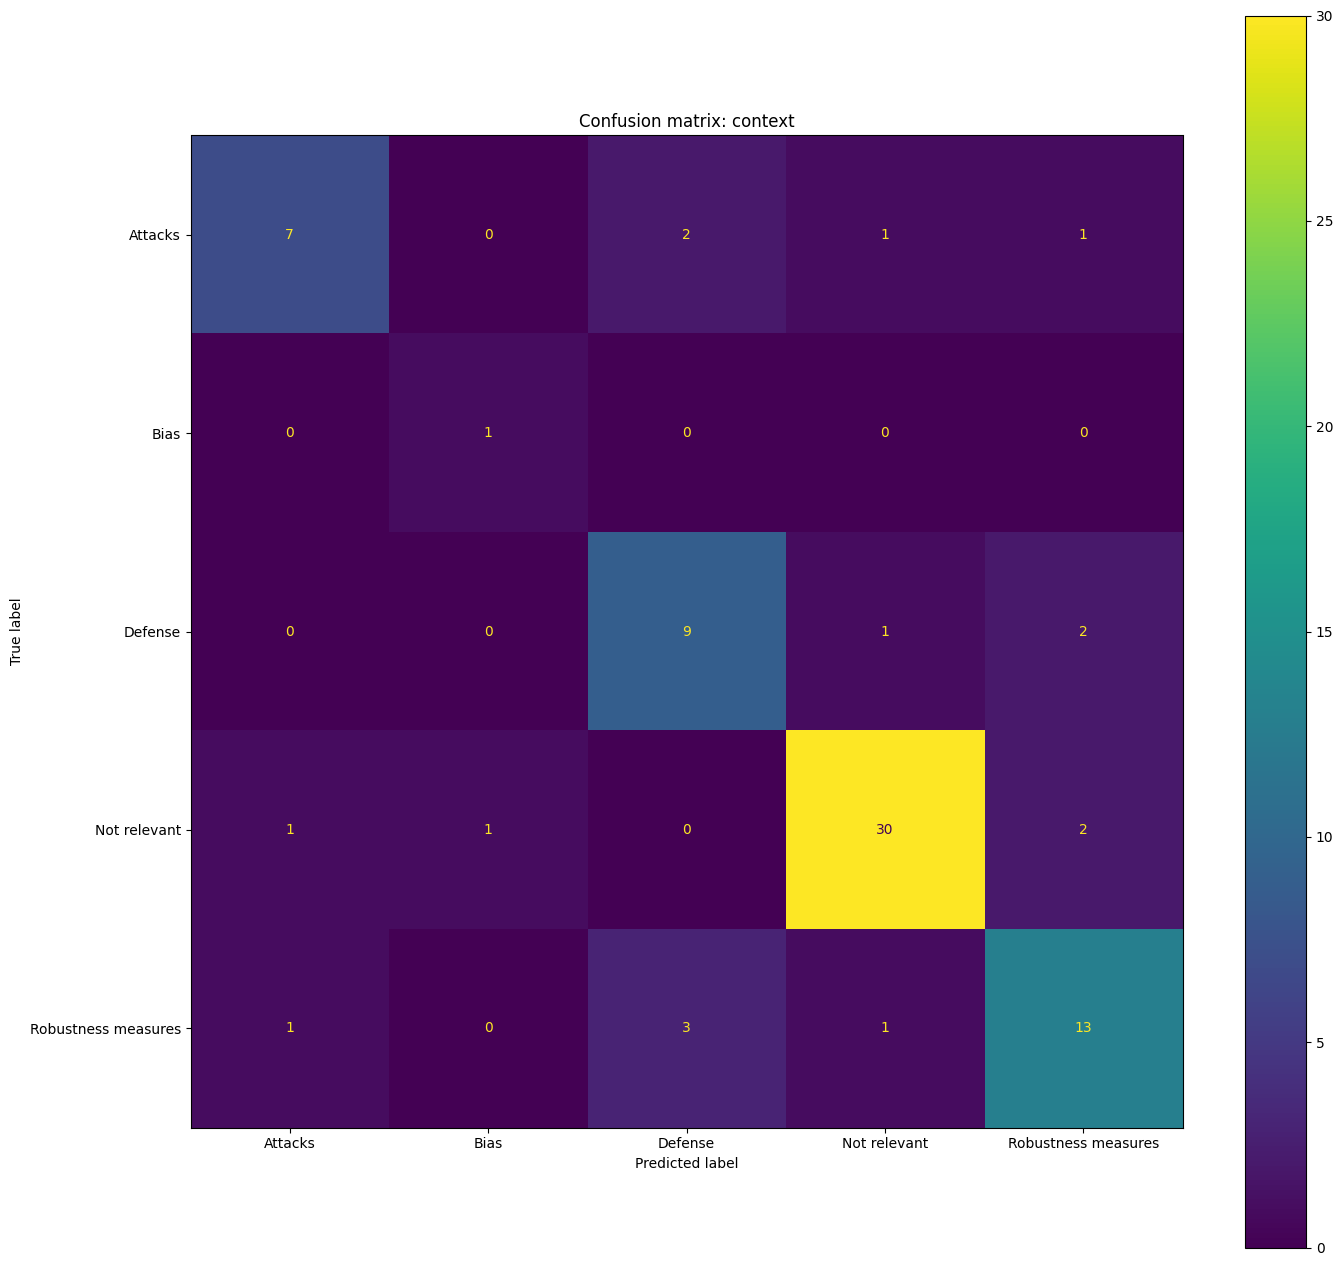

In [239]:
labels = sorted(df_context[["context_1", "context_pred"]].stack().unique())
cm = confusion_matrix(df_context["context_1"], df_context["context_pred"], labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_title("Confusion matrix: context")
ConfusionMatrixDisplay.from_predictions(df_context["context_1"], df_context["context_pred"], ax=ax)

Rows where I disagree with GPT on primary **context** label

In [197]:
df_context_1_disagree = df_context[df_context["context_1"] != df_context["context_pred"]]

In [198]:
context_disagreement_assessment = pd.Series(index=df_context_1_disagree.index, dtype=str, name="assessment")

In [199]:
ix = 15
id_ = df_context_1_disagree.index[ix]
print("me:", df_context_1_disagree.iloc[ix]["context_1"])
print("chatgpt:", df_context_1_disagree.iloc[ix]["context_pred"])
print()
print(df_context_1_disagree[["context_1", "context_pred", "abstract"]].iloc[ix]["abstract"])

me: Robustness measures
chatgpt: Defense

Reinforcement learning (RL) is inefficient on long-horizon tasks due to sparse rewards and its policy can be fragile to slightly perturbed environments. We address these challenges via a curriculum of tasks with coupled environments, generated by two policies trained jointly with RL: (1) a co-operative planning policy recursively decomposing a hard task into a coarse-to-fine sub-task tree; and (2) an adversarial policy modifying the environment in each sub-task. They are complementary to acquire more informative feedback for RL: (1) provides dense reward of easier sub-tasks while (2) modifies sub-tasks' environments to be more challenging and diverse. Conversely, they are trained by RL's dense feedback on sub-tasks so their generated curriculum keeps adaptive to RL's progress. The sub-task tree enables an easy-to-hard curriculum for every policy: its top-down construction gradually increases sub-tasks the planner needs to generate, while the ad

In [175]:
context_disagreement_assessment.loc[id_] = "Arguable"

In [176]:
#context_disagreement_assessment.to_csv("context_disagreement_assessment.csv")

In [177]:
context_disagreement_assessment = pd.read_csv("context_disagreement_assessment.csv").set_index("id")

Here, interpret "Wrong"/"Correct" as "ChatGPT is X".

In [178]:
fig = px.pie(
    context_disagreement_assessment,
    names="assessment",
    title="GPT 3.5 Da Vinci-003 ('Chat') resolution of <b>context</b> disagreements with manual annotation",
)
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent+label', textfont_size=20,)

### Consolidate everything into a dataframe to write to spreadsheet

Examples without ground truth:

In [251]:
# join model output to scraped data
df_output = pd.merge(
    df_icml_abs,
    df_ans_unlabeled.drop("response", axis=1),
    left_on="id",
    right_on="id",
    how="inner"
).set_index("id")

# apply aliases
df_output["threat_pred"] = df_output["threat_pred"].replace(threats_short, regex=True)
df_output["context_pred"] = df_output["context_pred"].replace(contexts_short, regex=True)

# clean few mangled answers
fix_threat = {
    "Addressing model bias" : "Bias",
    "Data poisoning attack" : "Poisoning",
    "Specific adversarial defense methods" : "Not relevant",
    # question got mangled in with answer twice
    "\('Robustness'\)": "Robustness"
}
df_output["threat_pred"] = df_output["threat_pred"].replace(fix_threat, regex=True)

fix_context = {
    "\('Robustness measures'\)" : "Robustness measures",
}
df_output["context_pred"] = df_output["context_pred"].replace(fix_context, regex=True)

# make sure context not defined if no adversarial threat defined
df_output.loc[df_output["threat_pred"] == "Not relevant", "context_pred"] = "Not relevant"
df_output.loc[df_output["threat_pred"] == "Not relevant", "techniques_pred"] = "None"

# add labelled test examples back
df_output = pd.concat([df_output, df_context])

In [252]:
df_output.to_csv("icml_output.csv")

# Throw all this away, nothing else is nearly as good

## Zero-shot classification

Flush VRAM

In [ ]:
import gc

try:
    del model
except NameError:
    pass
try:
    del classifier
except NameError: 
    pass
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

In [ ]:
base = "1.3b"
standard = "6.7b"

model = "facebook/bart-large-mnli"
model = f"facebook/galactica-{base}"

classifier = pipeline("zero-shot-classification",
                     model=model,
                     device=0)

### Predict Threat

In [ ]:
threat_labels = df_iclr["Threat"].unique()
print("candidate label s are: ", threat_labels)

Try different threat labels

In [ ]:
threat_labels = ["Model extraction attack", "Poisoning attack", "Data extraction attack", "Lack of robustness", "Adversarial attack"]
print("candidate label s are: ", threat_labels)

In [ ]:
pd.Series(index=df_test["abstract"].index, data="")

In [ ]:
def rule_based_classifier(
    abstracts: pd.Series,
    rules: dict[str, str] = None
) -> pd.Series:
    if rules is None:
        rules = {
            "model extraction": "Model extraction attack",
            "poisoning": "Poisoning attack",
            "data extraction": "Data extraction attack",
            "adversarial (noise|perturbation)": "Adversarial attack"
        }
    output = pd.Series(index=abstracts.index, data="")
    for keyword, label in rules.items():
        output = output + abstracts.str.contains(keyword) * label
    return output

In [ ]:
rule_based_classifier(df_test["abstract"])

In [ ]:
dataset = Dataset.from_pandas(df_test)
dataset.set_format("torch")

pred_threats = classifier(dataset["abstract"], threat_labels, multi_label=True)

df_pred_threats = (
    pd.concat(
        [pd.Series(data=t["scores"], index=t["labels"]) for t in pred_threats],
        axis=1
    ).T
    #.set_index(df_test.index)
)
df_test = pd.concat([df_test, df_pred_threats], axis=1)

In [ ]:
df = df_test[["title", "abstract", "id", "threat_1", "threat_2", *df_test.columns[-5:]]].head()

In [ ]:
df

In [ ]:
df.iloc[:, -5:].T.rank(ascending=False)

In [ ]:
(df_pred_threats.max(axis=1) > 0.5).sum()

### Predict Context

In [ ]:
context_labels = ['Defense', 'Attacks', 'Bias', 'Robustness measures']
print("candidate label s are: ", context_labels)

In [ ]:
pred_context = classifier(dataset["abstract"], context_labels, multi_label=True)
df_pred_context = (
    pd.concat(
        [pd.Series(data=t["scores"], index=t["labels"]) for t in pred_context],
        axis=1
    ).T
    .set_index(df_icml_abs.index)
)
df_icml = df_icml.join(df_pred_context)

In [ ]:
df_icml.to_csv(data_dir/"ICML_ZSC.csv")

## Few-shot classification

https://github.com/Pandora-Intelligence/classy-classification

In [ ]:
import spacy
import classy_classification

data = {
    "furniture": ["This text is about chairs.",
               "Couches, benches and televisions.",
               "I really need to get a new sofa."],
    "kitchen": ["There also exist things like fridges.",
                "I hope to be getting a new stove today.",
                "Do you also have some ovens."]
}

nlp = spacy.blank("en")
nlp.add_pipe(
    "text_categorizer",
    config={
        "data": data,
        "model": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        "device": "gpu"
    }
)

print(nlp("I am looking for kitchen appliances.")._.cats)

# Output:
#
# [{"label": "furniture", "score": 0.21}, {"label": "kitchen", "score": 0.79}]

## Classification with natural language prompt (Galactica)

## Technique

Flair NER?

### Load

In [ ]:
df_icml = pd.read_csv(data_dir/"ICML_ZSC.csv", index_col=0)

In [ ]:
df_icml[["Robustness", "Evasion", "Model Extraction", "Data Extraction", "Poisoning"]]

In [ ]:
import plotly.express as px

In [ ]:
px.histogram(df_icml[context_labels], barmode="overlay", title="Context")

In [ ]:
px.histogram(df_icml[threat_labels], barmode="overlay", title="Context")

Manual

In [ ]:
df_manual_check = (
    df_icml
    .loc[~pd.isnull(df_icml.abstract), ["id", "title", "abstract"]]
    .sample(50, random_state=10)
    .reset_index(drop=True)
)

In [ ]:
df_manual_check = pd.read_csv("manu.csv", index_col=0)

FSC + finetune galactica?

In [ ]:
ix = 0

Interesting ones:

- Pure Noise to the Rescue of Insufficient Data (1217)
- Towards Theoretical Analysis of Transformation Complexity of ReLU DNNs (2457)
- Evaluating the Adversarial Robustness of Adaptive Test-time Defenses (1456)
- Carlini et al. (2019) (referenced by ^)
- Probabilistically Robust Learning: Balancing Average- and Worst-case Performance (1877)
- Modeling Adversarial Noise for Adversarial Training (1591)

In [ ]:
df_manual_check.loc[ix, "abstract"]

In [ ]:
"Not relevant"

In [ ]:
print("Threats:", threat_labels)
df_manual_check.loc[ix, "threat_manual"] = "Not relevant"
print("Contexts:", context_labels)
df_manual_check.loc[ix, "context_manual"] = "Not relevant"

In [ ]:
ix+=1

In [ ]:
df_manual_check

In [ ]:
df_manual_check.to_csv("manu.csv")

Now for adversarial-only papers (non robustness)

In [ ]:
ix = 0

---

In [ ]:
df_icml_adv_sample.loc[ix, "abstract"]

In [ ]:
print("Threats:", threat_labels)
df_icml_adv_sample.loc[ix, "threat_manual"] = "Robustness"
print("Contexts:", context_labels)
df_icml_adv_sample.loc[ix, "context_manual"] = "Robustness measures"

In [ ]:
ix+=1

In [ ]:
df_icml_adv_sample.to_csv("manu_adv_only.csv")

In [ ]:
pd.concat([df_icml_adv_sample, df_manual_check], axis=0)

In [ ]:
df_icml_adv_sample

## Galactica

Flush VRAM

In [ ]:
import gc

try:
    del model
except NameError:
    pass
try:
    del classifier
except NameError: 
    pass
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

In [ ]:
from transformers import pipeline

base = "1.3b"
standard = "6.7b"

with torch.no_grad(): # clear GPU memory
    model = pipeline("text-generation", model=f"facebook/galactica-{base}", device=0)

In [ ]:
# prompt = input_text + "\n\nWhich techniques are described in the preceding passage? Answer:\n\n"
# prompt = input_text + "\n\nThe techniques described in the preceding passage can be listed succinctly as: "
# prompt = input_text + """
# \n\nWhich of the following attack types is most relevant to the previous passage?
# 'model extraction', 'data poisoning', 'data extraction', 'evasion attack', 'lack of robustness', or 'none'?
# """
# prompt = input_text + """
# \n\nDoes the preceding passage refer to 'model robustness' in general, or to any of the following attacks in adversarial machine learning: 
# 'model extraction', 'data poisoning', 'data extraction', or 'evasion attack'? Answer:\n\n
# """

In [ ]:
ix = 0

In [ ]:
input_text = df_test.loc[ix, "abstract"]

prompt = input_text + (
"Does this abstract pertain to adversarial machine learning?\n\n"
"If not, just answer 'No'. If so, answer with which of the following threats best is most relevant: "
"'Model extraction attack', 'Poisoning attack', 'Data extraction attack', 'Lack of robustness' or 'Adversarial attack'. "
"If you are not sure, answer with 'The answer is \"not sure\"'.\n\n"
"The answer is "
)
#prompt = input_text + "\n\nIs this passage about specifically *adversarial* machine learning?"

In [ ]:
input_text

In [ ]:
prompt

In [ ]:
output = model(prompt, max_new_tokens=40)
answer = output[0]["generated_text"][len(prompt):]
print(answer)